# CS 4340 Project 1 - Perceptron Learning Algorithm

**Names:** Tori S, Rashmika S

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import random

random.seed(42)

## Part A: Report

### Q1: How we generated the data

We made a random line (decision boundary) by picking random coefficients. Then we randomly sampled points from the square [-1,1] x [-1,1] and labeled each point based on which side of the line it's on. We kept sampling until we had 15 points of each class.

For non-separable data, we took the separable data and flipped 3 random labels.

In [2]:
# Make a random line w0 + w1*x1 + w2*x2 = 0
def random_line():
    w0 = random.uniform(-0.5, 0.5)
    w1 = random.uniform(-1, 1)
    w2 = random.uniform(-1, 1)
    # avoid line that's too flat
    while abs(w1) + abs(w2) < 0.3:
        w1 = random.uniform(-1, 1)
        w2 = random.uniform(-1, 1)
    return [w0, w1, w2]

# Label point based on line
def label_point(line, x1, x2):
    value = line[0] + line[1]*x1 + line[2]*x2
    return 1 if value >= 0 else -1

# Generate balanced dataset
def generate_data(line, n_per_class):
    data = []
    n_pos = 0
    n_neg = 0
    
    while n_pos < n_per_class or n_neg < n_per_class:
        x1 = random.uniform(-1, 1)
        x2 = random.uniform(-1, 1)
        y = label_point(line, x1, x2)
        
        if y == 1 and n_pos < n_per_class:
            data.append([x1, x2, y])
            n_pos += 1
        elif y == -1 and n_neg < n_per_class:
            data.append([x1, x2, y])
            n_neg += 1
    
    random.shuffle(data)
    return data

# Flip k random labels to make non-separable
def make_nonseparable(data, k):
    new_data = []
    for point in data:
        new_data.append([point[0], point[1], point[2]])
    
    indices = list(range(len(new_data)))
    random.shuffle(indices)
    
    for i in range(k):
        idx = indices[i]
        new_data[idx][2] = -new_data[idx][2]
    
    return new_data

In [3]:
# Generate all data
true_line = random_line()
print(f"True line: {true_line[0]:.3f} + {true_line[1]:.3f}*x1 + {true_line[2]:.3f}*x2 = 0")

train_sep = generate_data(true_line, 15)
test_data = generate_data(true_line, 5)
train_nonsep = make_nonseparable(train_sep, 3)

print(f"Training points: {len(train_sep)}")
print(f"Test points: {len(test_data)}")

True line: 0.139 + -0.950*x1 + -0.450*x2 = 0
Training points: 30
Test points: 10


## PLA Implementation

In [4]:
def predict(w, x1, x2):
    """Predict class of a point"""
    value = w[0] + w[1]*x1 + w[2]*x2
    return 1 if value >= 0 else -1

def error_rate(w, data):
    """Calculate percentage of misclassified points"""
    if len(data) == 0:
        return 0.0
    wrong = 0
    for point in data:
        if predict(w, point[0], point[1]) != point[2]:
            wrong += 1
    return 100.0 * wrong / len(data)

def train_perceptron(train_data, test_data, w_start, learning_rate, max_epochs=1000, point_order='sequential'):
    """Train PLA with pocket algorithm"""
    # Current weights
    w = [w_start[0], w_start[1], w_start[2]]
    # Best weights (pocket)
    w_pocket = [w_start[0], w_start[1], w_start[2]]
    best_err = error_rate(w_pocket, train_data)
    
    total_updates = 0
    total_epochs = 0
    
    for epoch in range(max_epochs):
        total_epochs += 1
        mistakes_this_epoch = 0
        
        # Choose order to visit points
        if point_order == 'sequential':
            order = list(range(len(train_data)))
        elif point_order == 'reversed':
            order = list(range(len(train_data)-1, -1, -1))
        else:  # shuffled
            order = list(range(len(train_data)))
            random.shuffle(order)
        
        # Go through each point
        for i in order:
            x1, x2, y_true = train_data[i]
            y_pred = predict(w, x1, x2)
            
            # If wrong, update weights
            if y_pred != y_true:
                w[0] = w[0] + learning_rate * y_true * 1
                w[1] = w[1] + learning_rate * y_true * x1
                w[2] = w[2] + learning_rate * y_true * x2
                
                total_updates += 1
                mistakes_this_epoch += 1
                
                # Check if better than pocket
                curr_err = error_rate(w, train_data)
                if curr_err < best_err:
                    best_err = curr_err
                    w_pocket = [w[0], w[1], w[2]]
        
        # If no mistakes, we converged
        if mistakes_this_epoch == 0:
            break
    
    # Return pocket weights
    final_train_err = error_rate(w_pocket, train_data)
    final_test_err = error_rate(w_pocket, test_data)
    
    return w_pocket, total_updates, total_epochs, final_train_err, final_test_err

## Helper functions

In [5]:
def plot_data(data, w, title):
    """Plot data points and decision boundary"""
    plt.figure(figsize=(7, 7))
    
    # Plot points
    for point in data:
        if point[2] == 1:
            plt.plot(point[0], point[1], 'bo', markersize=10, label='Class +1' if point == data[0] else '')
        else:
            plt.plot(point[0], point[1], 'rs', markersize=10, label='Class -1' if point == data[0] else '')
    
    # Plot line
    x_vals = np.linspace(-1.5, 1.5, 100)
    if abs(w[2]) > 0.001:
        y_vals = -(w[0] + w[1]*x_vals) / w[2]
        plt.plot(x_vals, y_vals, 'g-', linewidth=2, label='Decision boundary')
    
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

### Q2: Are test points linearly separable?

In [6]:
# Try to separate test data
w_test, _, _, test_train_err, _ = train_perceptron(test_data, [], [0,0,0], 1.0, 1000)
print(f"Test data linearly separable: {test_train_err < 0.1}")
print(f"Test data error when trying to separate: {test_train_err:.2f}%")

Test data linearly separable: True
Test data error when trying to separate: 0.00%


## CASE 1: Linearly Separable Training Data

CASE 1: LINEARLY SEPARABLE

Q3. Training data separable: True

Q4. Initial weights: [0, 0, 0]
    Learning rate: 1.0

Q5. Final decision boundary:
    0.0000 + -2.8393*x1 + -0.9526*x2 = 0
    x2 = -2.9807*x1 + 0.0000

Q6. Total updates: 6

Q7. Total epochs: 3

Q8. Training error: 0.00%
    Test error: 0.00%


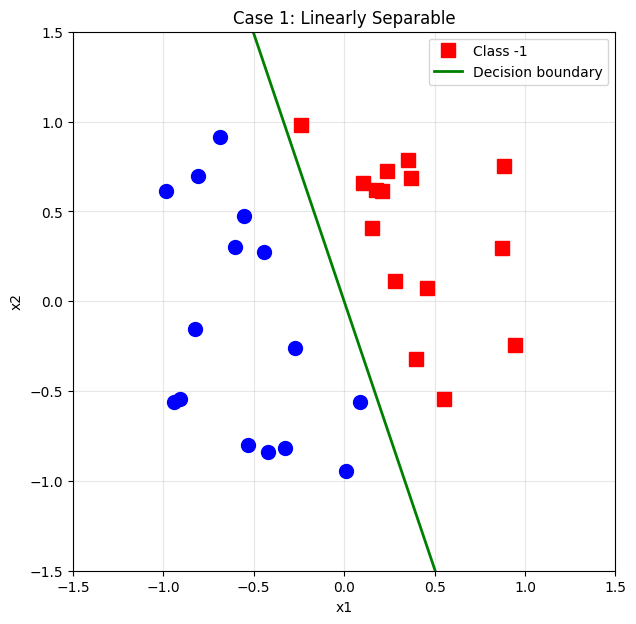

In [7]:
print("="*50)
print("CASE 1: LINEARLY SEPARABLE")
print("="*50)

# Q3
w_check, _, _, err_check, _ = train_perceptron(train_sep, [], [0,0,0], 1.0, 1000)
print(f"\nQ3. Training data separable: {err_check < 0.1}")

# Q4
w_init = [0, 0, 0]
eta = 1.0
print(f"\nQ4. Initial weights: {w_init}")
print(f"    Learning rate: {eta}")

# Train
w_final, updates, epochs, train_err, test_err = train_perceptron(train_sep, test_data, w_init, eta)

# Q5
print(f"\nQ5. Final decision boundary:")
print(f"    {w_final[0]:.4f} + {w_final[1]:.4f}*x1 + {w_final[2]:.4f}*x2 = 0")
if abs(w_final[2]) > 0.001:
    slope = -w_final[1]/w_final[2]
    intercept = -w_final[0]/w_final[2]
    print(f"    x2 = {slope:.4f}*x1 + {intercept:.4f}")

# Q6-8
print(f"\nQ6. Total updates: {updates}")
print(f"\nQ7. Total epochs: {epochs}")
print(f"\nQ8. Training error: {train_err:.2f}%")
print(f"    Test error: {test_err:.2f}%")

plot_data(train_sep, w_final, "Case 1: Linearly Separable")

## CASE 2: Non-Linearly Separable Training Data

CASE 2: NON-LINEARLY SEPARABLE

Q3. Training data separable: False

Q4. Initial weights: [0, 0, 0]
    Learning rate: 1.0

Q5. Final decision boundary:
    0.0000 + -1.6336*x1 + -0.2552*x2 = 0
    x2 = -6.4020*x1 + 0.0000

Q6. Total updates: 2411

Q7. Total epochs: 1000

Q8. Training error: 3.33%
    Test error: 0.00%


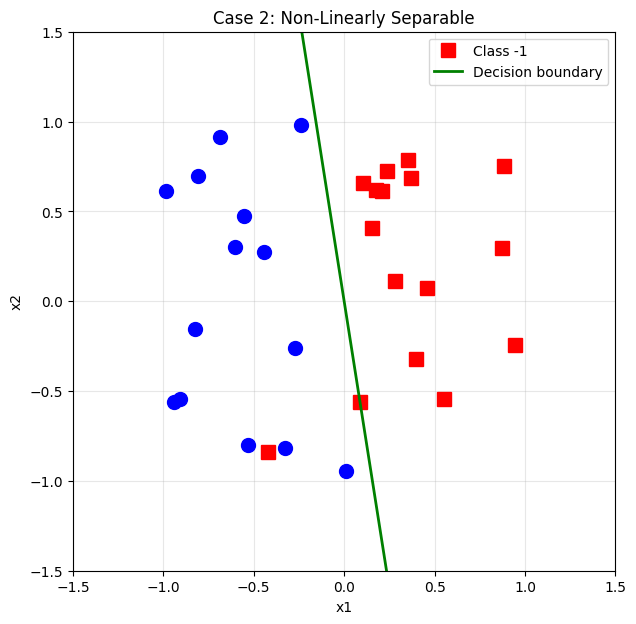

In [8]:
print("="*50)
print("CASE 2: NON-LINEARLY SEPARABLE")
print("="*50)

# Q3
w_check2, _, _, err_check2, _ = train_perceptron(train_nonsep, [], [0,0,0], 1.0, 1000)
print(f"\nQ3. Training data separable: {err_check2 < 0.1}")

# Q4
w_init2 = [0, 0, 0]
eta2 = 1.0
print(f"\nQ4. Initial weights: {w_init2}")
print(f"    Learning rate: {eta2}")

# Train
w_final2, updates2, epochs2, train_err2, test_err2 = train_perceptron(train_nonsep, test_data, w_init2, eta2, max_epochs=1000)

# Q5
print(f"\nQ5. Final decision boundary:")
print(f"    {w_final2[0]:.4f} + {w_final2[1]:.4f}*x1 + {w_final2[2]:.4f}*x2 = 0")
if abs(w_final2[2]) > 0.001:
    slope2 = -w_final2[1]/w_final2[2]
    intercept2 = -w_final2[0]/w_final2[2]
    print(f"    x2 = {slope2:.4f}*x1 + {intercept2:.4f}")

# Q6-8
print(f"\nQ6. Total updates: {updates2}")
print(f"\nQ7. Total epochs: {epochs2}")
print(f"\nQ8. Training error: {train_err2:.2f}%")
print(f"    Test error: {test_err2:.2f}%")

plot_data(train_nonsep, w_final2, "Case 2: Non-Linearly Separable")

## Q9: Varying Initial Weights

In [9]:
print("\nQ9: VARYING INITIAL WEIGHTS")
print("="*50)

different_inits = [
    [0, 0, 0],
    [1, 1, 1],
    [-0.5, 0.5, -0.5],
    [0.1, -0.2, 0.3]
]

print("\nSeparable case:")
for init_w in different_inits:
    w, upd, ep, tr_e, te_e = train_perceptron(train_sep, test_data, init_w, 1.0)
    print(f"  Init {init_w}: final=[{w[0]:.3f}, {w[1]:.3f}, {w[2]:.3f}], updates={upd}, epochs={ep}")

print("\nNon-separable case:")
for init_w in different_inits:
    w, upd, ep, tr_e, te_e = train_perceptron(train_nonsep, test_data, init_w, 1.0, 1000)
    print(f"  Init {init_w}: final=[{w[0]:.3f}, {w[1]:.3f}, {w[2]:.3f}], train_err={tr_e:.1f}%")


Q9: VARYING INITIAL WEIGHTS

Separable case:
  Init [0, 0, 0]: final=[0.000, -2.839, -0.953], updates=6, epochs=3
  Init [1, 1, 1]: final=[0.000, -2.680, -1.075], updates=9, epochs=4
  Init [-0.5, 0.5, -0.5]: final=[0.500, -2.595, -1.395], updates=11, epochs=5
  Init [0.1, -0.2, 0.3]: final=[0.100, -2.235, -0.985], updates=4, epochs=2

Non-separable case:
  Init [0, 0, 0]: final=[0.000, -1.634, -0.255], train_err=3.3%
  Init [1, 1, 1]: final=[0.000, -2.285, -0.361], train_err=3.3%
  Init [-0.5, 0.5, -0.5]: final=[-0.500, -1.870, -0.630], train_err=6.7%
  Init [0.1, -0.2, 0.3]: final=[0.100, -1.635, -0.082], train_err=3.3%


## Q10: Varying Learning Rate

In [10]:
print("\nQ10: VARYING LEARNING RATE")
print("="*50)

learning_rates = [0.1, 0.5, 1.0, 2.0]

print("\nSeparable case:")
for lr in learning_rates:
    w, upd, ep, tr_e, te_e = train_perceptron(train_sep, test_data, [0,0,0], lr)
    print(f"  eta={lr}: final=[{w[0]:.3f}, {w[1]:.3f}, {w[2]:.3f}], updates={upd}, epochs={ep}")

print("\nNon-separable case:")
for lr in learning_rates:
    w, upd, ep, tr_e, te_e = train_perceptron(train_nonsep, test_data, [0,0,0], lr, 1000)
    print(f"  eta={lr}: final=[{w[0]:.3f}, {w[1]:.3f}, {w[2]:.3f}], train_err={tr_e:.1f}%")


Q10: VARYING LEARNING RATE

Separable case:
  eta=0.1: final=[0.000, -0.284, -0.095], updates=6, epochs=3
  eta=0.5: final=[0.000, -1.420, -0.476], updates=6, epochs=3
  eta=1.0: final=[0.000, -2.839, -0.953], updates=6, epochs=3
  eta=2.0: final=[0.000, -5.679, -1.905], updates=6, epochs=3

Non-separable case:
  eta=0.1: final=[0.000, -0.163, -0.026], train_err=3.3%
  eta=0.5: final=[0.000, -0.817, -0.128], train_err=3.3%
  eta=1.0: final=[0.000, -1.634, -0.255], train_err=3.3%
  eta=2.0: final=[0.000, -3.267, -0.510], train_err=3.3%


## Q11: Varying Point Order

In [11]:
print("\nQ11: VARYING POINT ORDER")
print("="*50)

orders = ['sequential', 'reversed', 'shuffled']

print("\nSeparable case:")
for order in orders:
    w, upd, ep, tr_e, te_e = train_perceptron(train_sep, test_data, [0,0,0], 1.0, point_order=order)
    print(f"  Order={order}: final=[{w[0]:.3f}, {w[1]:.3f}, {w[2]:.3f}], updates={upd}, epochs={ep}")

print("\nNon-separable case:")
for order in orders:
    w, upd, ep, tr_e, te_e = train_perceptron(train_nonsep, test_data, [0,0,0], 1.0, 1000, point_order=order)
    print(f"  Order={order}: final=[{w[0]:.3f}, {w[1]:.3f}, {w[2]:.3f}], train_err={tr_e:.1f}%")


Q11: VARYING POINT ORDER

Separable case:
  Order=sequential: final=[0.000, -2.839, -0.953], updates=6, epochs=3
  Order=reversed: final=[0.000, -1.921, -0.628], updates=4, epochs=2
  Order=shuffled: final=[0.000, -0.541, -0.405], updates=2, epochs=2

Non-separable case:
  Order=sequential: final=[0.000, -1.634, -0.255], train_err=3.3%
  Order=reversed: final=[0.000, -1.849, -0.184], train_err=3.3%
  Order=shuffled: final=[0.000, -3.606, -0.269], train_err=3.3%


## Part C: Save Data

In [12]:
# Save to CSV files
with open('train_separable.csv', 'w') as f:
    f.write('x1,x2,y\n')
    for p in train_sep:
        f.write(f'{p[0]},{p[1]},{p[2]}\n')

with open('train_nonseparable.csv', 'w') as f:
    f.write('x1,x2,y\n')
    for p in train_nonsep:
        f.write(f'{p[0]},{p[1]},{p[2]}\n')

with open('test_data.csv', 'w') as f:
    f.write('x1,x2,y\n')
    for p in test_data:
        f.write(f'{p[0]},{p[1]},{p[2]}\n')

print("Data saved!")

Data saved!


Tori St. John and Rashmika Srivastava certify that this report is
my/our own, independent work, that it does not plagiarize, in part or in full, any other work, and
that no use of generative AI has been made in this project.